# Random Forest Classifier Baseline (Model Comparison) v3

- 모델 종류 체급 비교 목적

평가 (Test set):
- PR-AUC
- Recall (Churn)
- Accuracy
- Confusion Matrix
- Classification Report
- Feature Importance


In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)


In [2]:
df = pd.read_parquet('data/kkbox_train_feature_v3.parquet')


In [3]:
RANDOM_STATE = 719

ID_COL = "msno"
TARGET_COL = "is_churn"

CATEGORICAL_COLS = [
    "city", "gender", "registered_via", "last_payment_method",
    "has_ever_paid", "has_ever_cancelled", "is_free_user",
    "is_auto_renew_last"
]

NUMERICAL_COLS = [
    "reg_days",
    "num_days_active_w7", "total_secs_w7", "avg_secs_per_day_w7", "std_secs_w7",
    "num_songs_w7", "avg_songs_per_day_w7", "num_unq_w7", "num_25_w7", "num_100_w7",
    "short_play_w7", "skip_ratio_w7", "completion_ratio_w7", "short_play_ratio_w7", "variety_ratio_w7",
    "num_days_active_w14", "total_secs_w14", "avg_secs_per_day_w14", "std_secs_w14",
    "num_songs_w14", "avg_songs_per_day_w14", "num_unq_w14", "num_25_w14", "num_100_w14",
    "short_play_w14", "skip_ratio_w14", "completion_ratio_w14", "short_play_ratio_w14", "variety_ratio_w14",
    "num_days_active_w21", "total_secs_w21", "avg_secs_per_day_w21", "std_secs_w21",
    "num_songs_w21", "avg_songs_per_day_w21", "num_unq_w21", "num_25_w21", "num_100_w21",
    "short_play_w21", "skip_ratio_w21", "completion_ratio_w21", "short_play_ratio_w21", "variety_ratio_w21",
    "num_days_active_w30", "total_secs_w30", "avg_secs_per_day_w30", "std_secs_w30",
    "num_songs_w30", "avg_songs_per_day_w30", "num_unq_w30", "num_25_w30", "num_100_w30",
    "short_play_w30", "skip_ratio_w30", "completion_ratio_w30", "short_play_ratio_w30", "variety_ratio_w30",
    "secs_trend_w7_w30", "secs_trend_w14_w30", "days_trend_w7_w14", "days_trend_w7_w30",
    "songs_trend_w7_w30", "songs_trend_w14_w30", "skip_trend_w7_w30", "completion_trend_w7_w30",
    "days_since_last_payment", "days_since_last_cancel", "last_plan_days",
    "total_payment_count", "total_amount_paid", "avg_amount_per_payment",
    "unique_plan_count", "subscription_months_est", "payment_count_last_30d", "payment_count_last_90d",
]

FEATURE_COLS = CATEGORICAL_COLS + NUMERICAL_COLS

X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].astype(int).copy()

## 1. Train / Test Split


In [4]:
from sklearn.model_selection import train_test_split

X = df[FEATURE_COLS]
y = df[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print(X_train.shape, X_test.shape)


(688772, 83) (172194, 83)


## 2. Column Groups


In [5]:
cat_cols = [c for c in CATEGORICAL_COLS if c in X_train.columns]
num_cols = [c for c in NUMERICAL_COLS if c in X_train.columns]

print(f"num_cols: {len(num_cols)}")
print(f"cat_cols: {len(cat_cols)}")


num_cols: 75
cat_cols: 8


## 3. Preprocessing (OHE only)


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

X_train_t = preprocess.fit_transform(X_train)
X_test_t = preprocess.transform(X_test)


## 4. Random Forest Classifier Model


In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)


## 5. Train Model


In [8]:
rf_model.fit(X_train_t, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",800
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## 6. Test Evaluation


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

y_proba = rf_model.predict_proba(X_test_t)[:, 1]
y_pred  = rf_model.predict(X_test_t)

print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")
print(f"Recall (Churn): {recall_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


PR-AUC: 0.9235
Recall (Churn): 0.8107
Accuracy: 0.9729


## 7. Confusion Matrix


In [10]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])


,Pred 0,Pred 1
Actual 0,154319,1585
Actual 1,3084,13206


## 8. Classification Report


In [11]:
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9804    0.9898    0.9851    155904
           1     0.8928    0.8107    0.8498     16290

    accuracy                         0.9729    172194
   macro avg     0.9366    0.9003    0.9174    172194
weighted avg     0.9721    0.9729    0.9723    172194



## 9. Feature Importance (Impurity Decrease)


In [12]:
feature_names = preprocess.get_feature_names_out()
importances = rf_model.feature_importances_

imp_rf_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

imp_rf_df


,feature,importance
66,num__days_since_last_cancel,7.694808e-02
140,cat__has_ever_cancelled_1,7.384426e-02
69,num__total_amount_paid,7.283541e-02
72,num__subscription_months_est,6.539662e-02
139,cat__has_ever_cancelled_0,6.396427e-02
74,num__payment_count_last_90d,5.634683e-02
143,cat__is_auto_renew_last_0,4.977915e-02
144,cat__is_auto_renew_last_1,4.551291e-02
68,num__total_payment_count,4.092918e-02
70,num__avg_amount_per_payment,3.938822e-02


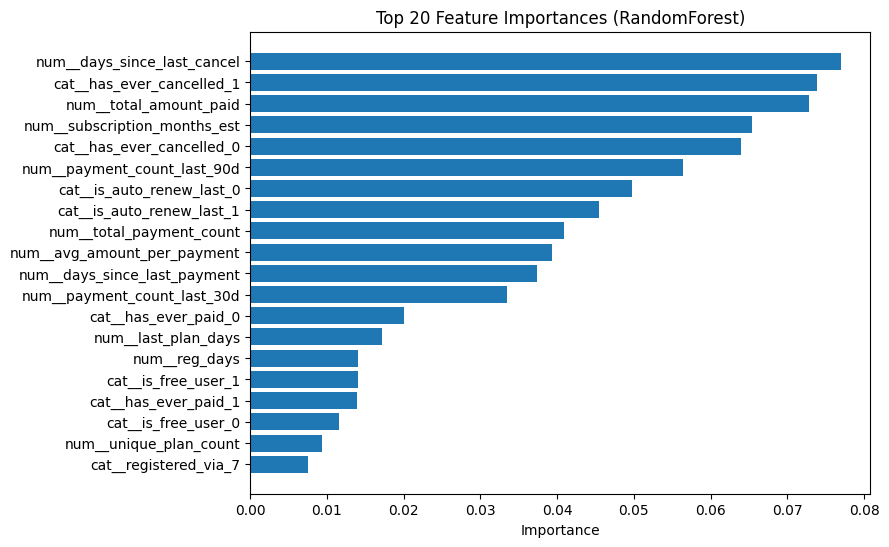

In [14]:
import matplotlib.pyplot as plt

top_n = 20
top_imp = imp_rf_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.gca().invert_yaxis()  # 중요도가 높은 게 위로 오게
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()


In [13]:
# imp_rf_df.to_csv(
#     "data/model_df/rf_feature_importance_19.csv",
#     index=False
# )
